# FiberNET: experiments in 2D

We consider in this example the generic conduction velocity field in $\mathbb{R}^{2\times 2}$ defined as follows:
$$
\mathbf{D} = v_t^2(x) \mathbf{I} + \bigl(v_\ell^2(x)-v_t^2(x)\bigr)\boldsymbol{\ell}(x)\otimes\boldsymbol{\ell}(x),
$$
where $\boldsymbol{\ell}(x)$ is the local fiber direction, defined as:
$$
\boldsymbol{\ell}(x) = a(x)\,\vec{e}_1 + \sqrt{1-a(x)^2}\,\vec{e}_2,
$$
with $a(x)\in[-1,1]$.

For this specific experiment, we select $v_\ell$, $v_t$ and $a$ piecewise constant, as in [2D_example.ipynb](2D_example.ipynb), but we change the anisotropy ratio in the two regions.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize, BoundaryNorm

from FiberNetModels_2D import MultiAnisoEikonalPINN_2D, SyntheticDataGenerator2D, D_printer

Import of Cupy failed. The GPU version of fimpy will be unavailble. Message: No module named 'cupy'


In [90]:
# We override the default behaviour of CV

class Example2DAniso(SyntheticDataGenerator2D):

    def __init__(self,vl,vt,a,**kwargs):
        self.vt = vt
        self.vl = vl
        self.a  = a
        super().__init__(**kwargs)

    def get_simulated_CV(self,X,Y):
        vl = self.vl(X,Y)
        vt = self.vt(X,Y)
        a  = self.a(X,Y)

        l  = np.dstack([a, np.sqrt(1-a**2)])
        t  = np.dstack([-np.sqrt(1-a**2), a])
        el = vl[...,np.newaxis]**2 * l
        et = vt[...,np.newaxis]**2 * t

        DD = el[...,np.newaxis] * l[...,np.newaxis,:] + et[...,np.newaxis] * t[...,np.newaxis,:]

        d1,d12,d2 = DD[...,0,0], DD[...,0,1], DD[...,1,1]
        e1x,e1y   = el[...,0],el[...,1]
        e2x,e2y   = et[...,0],et[...,1]

        return np.array([e1x, e1y, e2x, e2y, d1, d2, d12])

In [95]:
#@title Inputs
# These data files are 3D meshes with data
maps_number = 2 #@param {type:"slider", min:1, max:5, step:1}
sample_points = 245 #@param {type:"slider", min:1, max:1500, step:1}
noise_ms = 0.0 #@param {type:"slider", min:0.0, max:5.0, step:0.1}

vl = lambda x,y: np.where(x + y < 0,  1.0, 1.0)
vt = lambda x,y: np.where(x + y < 0, 0.75, 0.5)
a  = lambda x,y: np.where(x + y < 0,  1.0, 0.0)

print(f"Selected values -> maps: {maps_number}, sample points: {sample_points}, noise (ms): {noise_ms}")

Selected values -> maps: 2, sample points: 245, noise (ms): 0.0


In [92]:
# Initialize seed
np.random.seed(0)
tf.random.set_seed(0)

# Assign basic variable values
layers = [3] + [10] * 5 + [1]
CVlayers = [3] + [5] * 5 + [3]
grid_points = 35


# call datagenerator and get fields
synthetic_values = Example2DAniso(vl,vt,a,grid_points=grid_points, sample_points=sample_points, maps_number=maps_number)
points, triangs, X_mesh, Y_mesh = synthetic_values.get_geometry()
act_times_ref, X_e, T_e, Tmax = synthetic_values.get_activation_maps()
fiber_vecs, cv = synthetic_values.get_fiber_vectors()

# Model initialization
model = MultiAnisoEikonalPINN_2D(points, triangs, maps_number, X_e, T_e,
                        layers, CVlayers, Tmax,
                        CVmax=1.,
                        lambda_pde=1.e-2,
                        lambda_tve=1.*10**-5,
                        lambda_tva=1.*10**-9,
                        lambda_df=1.e0)

# Model training
loss_curve = model.train_Adam_minibatch(int(3e3), size=32)
act_times, CV_out, CV_x, D_2D, D_out, evals, evecs, eik_mismatch = model.predict(points)
x_e = model.X_e

predicted_vecs_3D = np.linalg.eigh(D_out)[1] # Eigenvectors of model values at centroids
D1x, D1y, D2x, D2y = D_printer(D_out)

D_mismatch_rad = np.arccos(np.clip(np.abs(np.sum(fiber_vecs[..., :, 2]*predicted_vecs_3D[..., :, 2],1)),0.,1.))
fiber_orientation_error = np.rad2deg(np.mean(D_mismatch_rad))
D_mismatch_degree_dist = np.rad2deg(np.percentile(D_mismatch_rad, [25,50,75]))
data_fidelity_error = np.sqrt(np.mean((act_times-act_times_ref)**2))

model.sess.close()
tf.compat.v1.reset_default_graph()

print("---Final results---")
print("Mean fiber orientation error: " + str(fiber_orientation_error) + "°")
print("25-50-75 percentiles fiber orientation error: " + str(D_mismatch_degree_dist) + " (°)")
print("RMSE for data fidelity: " + str(data_fidelity_error) + " ms")

Real number of sample points taken:  226


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

---Final results---
Mean fiber orientation error: 8.490055057865463°
25-50-75 percentiles fiber orientation error: [2.29925041 2.68940858 3.89194019] (°)
RMSE for data fidelity: 0.010729723 ms


## Estimated fibers and velocities

Text(0.5, 1.0, 'Angle')

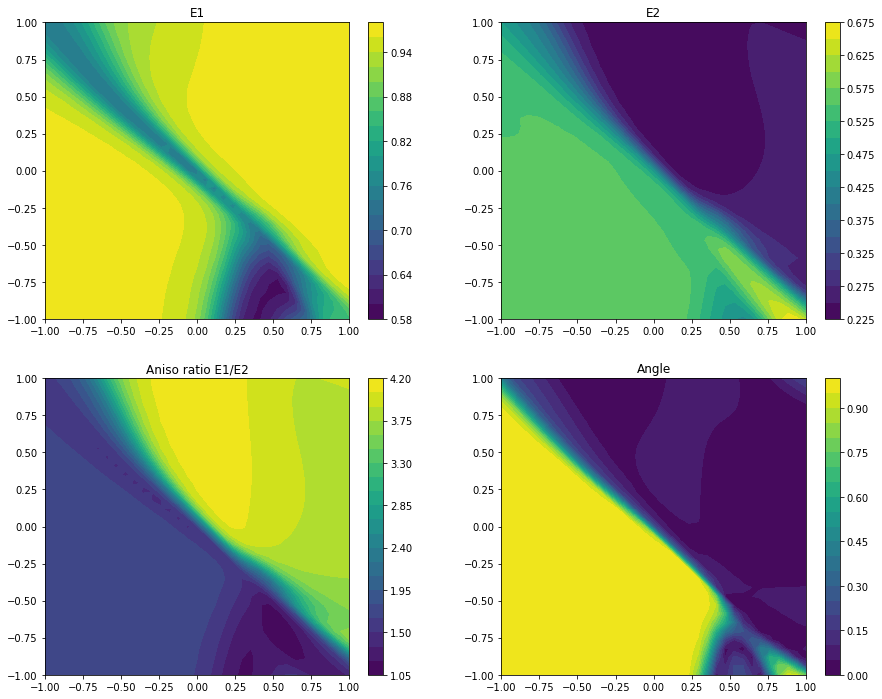

In [93]:
carray = np.arange(11)*0.3
scale = 2
norm = Normalize(vmin=0.,vmax=90.,clip=False)
norms = BoundaryNorm(boundaries=carray, ncolors=256)
colormap = cm.inferno_r
colormapr = cm.jet_r

fig, axs = plt.subplots(2, 2, figsize=(15,12))
D1x, D1y, D2x, D2y = D_printer(D_out)

E1 = np.sqrt(D1x**2+D1y**2)
E2 = np.sqrt(D2x**2+D2y**2)
AA = D1x/E1
LL = E1/E2

c1 = axs[0,0].contourf(X_mesh,Y_mesh,E1.reshape(X_mesh.shape),20)
plt.colorbar(c1,ax=axs[0,0])
c2 = axs[0,1].contourf(X_mesh,Y_mesh,E2.reshape(X_mesh.shape),20)
plt.colorbar(c2,ax=axs[0,1])
c3 = axs[1,0].contourf(X_mesh,Y_mesh,LL.reshape(X_mesh.shape),20)
plt.colorbar(c3,ax=axs[1,0])
c4 = axs[1,1].contourf(X_mesh,Y_mesh,AA.reshape(X_mesh.shape),20)
plt.colorbar(c4,ax=axs[1,1])

axs[0,0].set_title(f"E1")
axs[0,1].set_title(f"E2")
axs[1,0].set_title(f"Aniso ratio E1/E2")
axs[1,1].set_title(f"Angle")

## Predicted maps

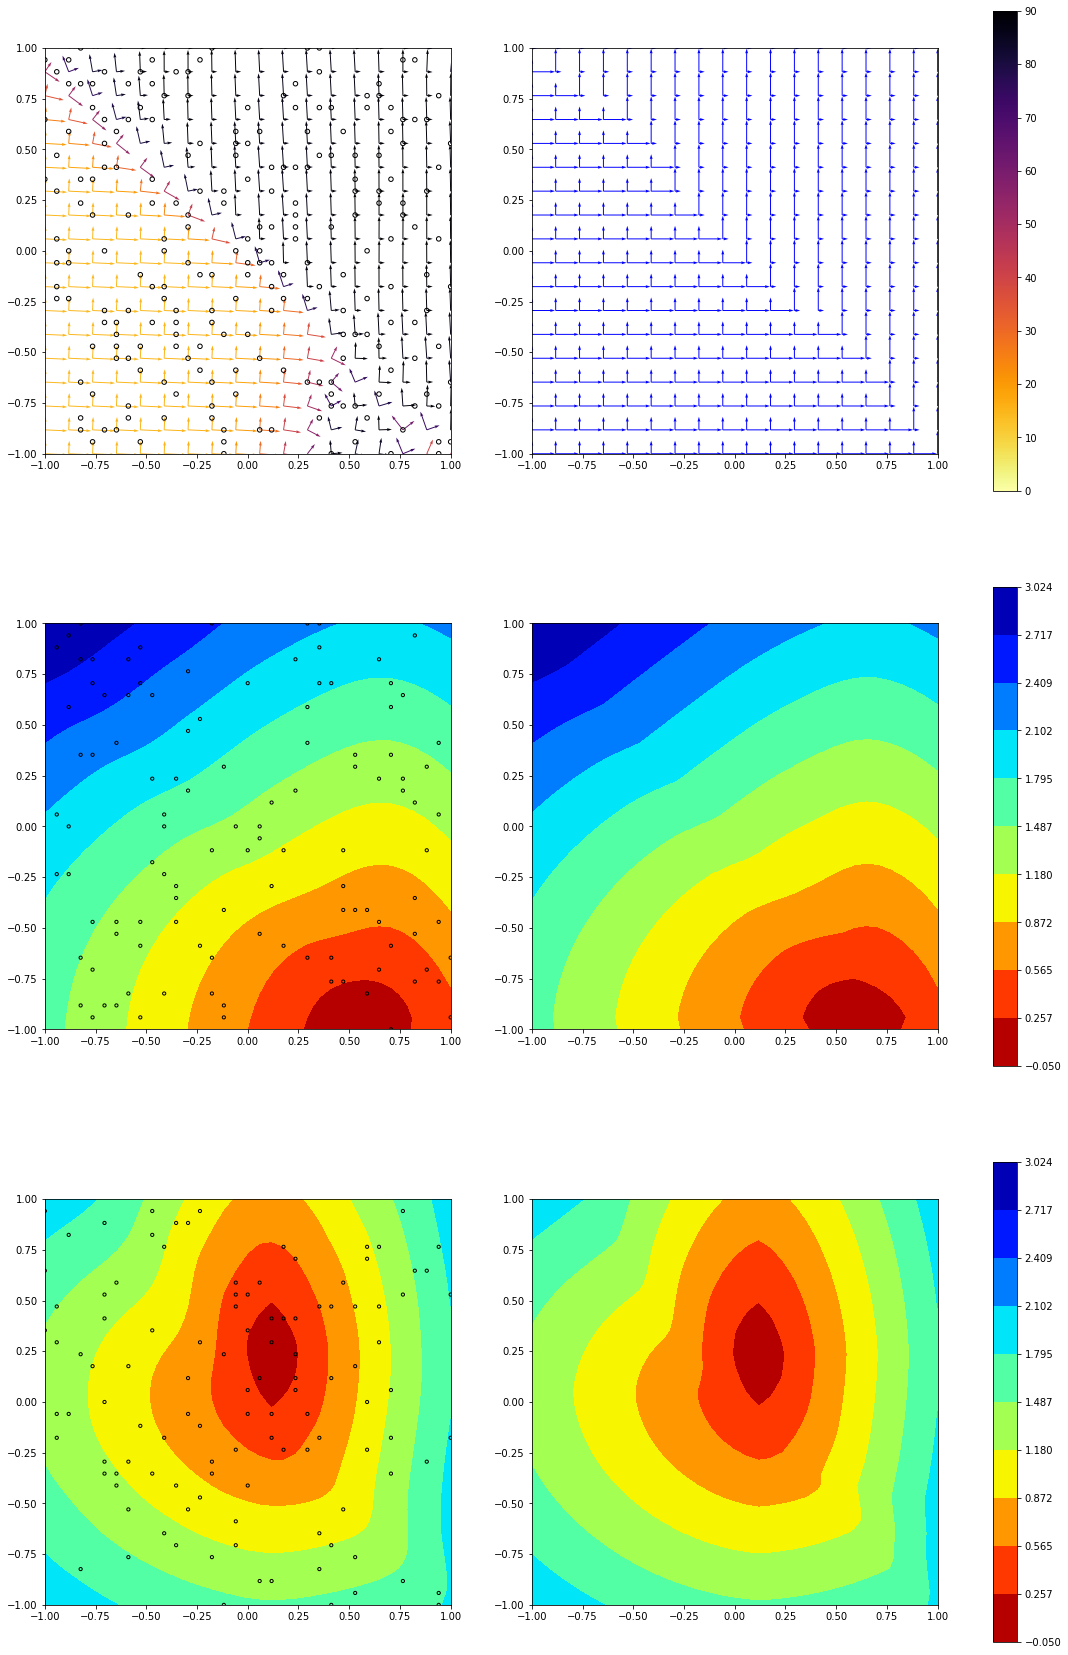

In [94]:
carray = np.linspace(act_times.min(),act_times.max(),11)+1e-3 # np.arange(11)*0.4
scale = 2
norm = Normalize(vmin=0.,vmax=90.,clip=False)
norms = BoundaryNorm(boundaries=carray, ncolors=256)
colormap = cm.inferno_r
colormapr = cm.jet_r

fig, axs = plt.subplots(maps_number + 1, 2, figsize=(20,30))
D1x, D1y, D2x, D2y = D_printer(D_out)

for i in np.arange(maps_number):
    ctrf = axs[i+1,1].contourf(X_mesh, Y_mesh, act_times_ref[:,i].reshape(X_mesh.shape),carray,cmap=colormapr)
    axs[i+1,1].set_xlim([-1,1])
    axs[i+1,1].set_ylim([-1,1])
    axs[i+1,1].set_aspect('equal')
    fig.colorbar(ctrf, ax=axs[i+1,:], ticks=carray)

    ctrf = axs[i+1,0].contourf(X_mesh, Y_mesh, act_times[:,i].reshape(X_mesh.shape),carray,cmap=colormapr)
    axs[i+1,0].scatter(x_e[:,0,i], x_e[:,1,i], facecolors = 'none', edgecolor = 'k', s=10)
    axs[i+1,0].set_xlim([-1,1])
    axs[i+1,0].set_ylim([-1,1])
    axs[i+1,0].set_aspect('equal')

for l in range(len(cv[0])):
    if np.mod(l,scale)!=0 or np.mod(l//grid_points,scale)!=0:
        cv[0,l]=cv[1,l]=cv[2,l]=cv[3,l]=0
#ratio = np.sqrt(cv[0]**2+cv[1]**2)/np.sqrt(cv[2]**2+cv[3]**2)

axs[0,1].quiver(X_mesh, Y_mesh, abs(cv[0]), cv[1], color='b', scale=grid_points/scale, minlength=0.0001)
axs[0,1].quiver(X_mesh, Y_mesh, abs(cv[2]), cv[3], color='b', scale=grid_points/scale, minlength=0.0001)
axs[0,1].set_xlim([-1,1])
axs[0,1].set_ylim([-1,1])
axs[0,1].set_aspect('equal')

for l in range(len(D1x)):
    if not -np.pi/4 < np.arctan2(D1y[l],D1x[l]) < np.pi*3/4:
        D1x[l]=-D1x[l]
        D1y[l]=-D1y[l]
    if not -np.pi/4 < np.arctan2(D2y[l],D2x[l]) < np.pi*3/4:
        D2x[l]=-D2x[l]
        D2y[l]=-D2y[l]
    if np.mod(l,scale)!=0 or np.mod(l//grid_points,scale)!=0:
        D1x[l]=D2x[l]=D1y[l]=D2y[l]=0

fo = np.squeeze(np.rad2deg(np.arccos(np.clip(np.abs(np.diagonal(np.dot(cv[:2].T,np.hstack([D1x[:,np.newaxis],D1y[:,np.newaxis]]).T))),0.,1.))))
#ratio = np.sqrt(D1x**2+D1y**2)/np.sqrt(D2x**2+D2y**2)

qvr = axs[0,0].quiver(X_mesh, Y_mesh, D1x, D1y, color=colormap(norm(fo)), scale=grid_points/scale, minlength=0.0001)
axs[0,0].quiver(X_mesh, Y_mesh, D2x, D2y, color=colormap(norm(fo)), scale=grid_points/scale, minlength=0.0001)
axs[0,0].scatter(x_e[:,0].flatten(), x_e[:,1].flatten(), facecolors = 'none', edgecolor = 'k', s=20)
axs[0,0].set_xlim([-1,1])
axs[0,0].set_ylim([-1,1])
axs[0,0].set_aspect('equal')
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=colormap), ax=axs[0,:])